# Modeling

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
import time
import os

# Utils
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

# Metrics
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import precision_score, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc

# classificadores
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

# removendo avisos de atualizacao de bibliotecas
import warnings
warnings.filterwarnings("ignore")

# importando o pacote com funções auxiliares
import sys
sys.path.append('../')
from lib import customPlots

In [17]:
# Macros

SEED = 2021
CLASS = "country_destination"
MAIN_CLASS_AUC = "NDF"
COLS_TO_REMOVE = ['Unnamed: 0']

DOWNSAMPLE = False
N_PER_CLASS = 20000
APPLY_SMOTE = False
WEIGHTED_TRAIN = False
TREE_MAX_DEPTH = 6

DATA_PATH = 'data/df_train.csv'
PREPARATION_PATH = 'outputs/data_pipeline.sav'
RESULTS_PATH = 'data/results.csv'
MODEL_PATH = 'outputs/model.sav'

In [3]:
df = pd.read_csv(DATA_PATH)

# Removendo atributos que não acrescentam informações no modelo
df.drop(COLS_TO_REMOVE, axis=1, inplace=True)
df = df.set_index('id')
df.head().T

id,wqpe22hwjb,l144s4m9mu,y6extte83s,1u2r6m6ets,oleaq2ki3k
date_account_created,2014-05-20,2014-01-14,2012-02-09,2013-07-01,2013-10-15
timestamp_first_active,20140520182222,20140114180853,20120209001110,20130701060451,20131015032212
gender,-unknown-,FEMALE,-unknown-,MALE,-unknown-
age,NaN,28.0,NaN,30.0,57.0
signup_method,basic,basic,basic,basic,basic
signup_flow,0,0,0,0,0
language,en,en,en,en,en
affiliate_channel,sem-non-brand,other,direct,direct,direct
affiliate_provider,google,other,direct,direct,direct
first_affiliate_tracked,omg,omg,NaN,omg,untracked


## Auxiliar Functions

In [4]:
def encode(arr):
    le = preprocessing.LabelEncoder()
    arr = np.where(arr != MAIN_CLASS_AUC, 'Others', arr)
    return le.fit_transform(arr)

def plot_charts(y_test, y_pred, name='', idx=0):
    fig = plt.figure(figsize=(12, 12), facecolor='w')

    cm=confusion_matrix(y_test, y_pred)
    c_matrix = customPlots.ConfusionMatrix()
    c_matrix.plot(cm,
                  classes=np.unique(y_test),
                  title=f'Matriz de confusão {name}',
                  fig=fig,
                  subplot_index=1+idx)
    
    auc_chart = customPlots.AUC()
    auc = auc_chart.plot(encode(y_test), encode(y_pred), title=f"AUC {name}", subplot_index=2+idx)
    return auc

def save_results(name):
    results = pd.read_csv(RESULTS_PATH)
    data = pd.DataFrame.from_dict({
        'clf': [name],
        'test_logloss': [test_logloss],
        'val_logloss': [val_logloss],
        'test_auc': [test_auc],
        'val_auc': [val_auc],
        'downsample': [DOWNSAMPLE],
        'n_per_class': [N_PER_CLASS],
        'smote': [APPLY_SMOTE],
        'weighted_train': [WEIGHTED_TRAIN],
    })

    results = results.append(data, ignore_index=True, verify_integrity=False, sort=None)
    results.to_csv(RESULTS_PATH, index=False)

In [5]:
train, test = train_test_split(df, random_state=SEED, test_size=0.3)
test, val = train_test_split(df, random_state=SEED, test_size=0.3)

# Class balancing

In [6]:
counts = pd.DataFrame(train[CLASS]).value_counts()
max_count = max(counts)
counts

country_destination
NDF                    65400
US                     32717
FR                      2662
IT                      1478
dtype: int64

In [7]:
classes = df[CLASS].unique()

if DOWNSAMPLE:
    new = pd.DataFrame()
    for item in classes:
        df_sample = train[train[CLASS]==item]
        length = df_sample.shape[0]
        if length > N_PER_CLASS:
            df_sample = df_sample.sample(N_PER_CLASS)
        new = new.append(df_sample)
    train = new.copy()

print(pd.DataFrame(train[CLASS]).value_counts())

country_destination
NDF                    65400
US                     32717
FR                      2662
IT                      1478
dtype: int64


# Pre processing

In [8]:
def prep(df):
    preparacao = joblib.load(PREPARATION_PATH)
    df_y = df[CLASS].values
    df_X = df.drop(labels=[CLASS], axis=1)
    df_X = preparacao.transform(df_X)
    return df_X, df_y

train_X, train_y = prep(train)
test_X, test_y = prep(test)
val_X, val_y = prep(val)
test_X.head()

,timestamp_first_active,first_active_on_creation_date,register_year,register_month,register_day,register_weekday,age,signup_flow,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,2.013083e+13,1.0,2013.0,8.0,28.0,3.0,0.111111,0.0,0.0,0.0,5.0,5.0,7.0,1.0,2.0,3.0,32.0
1,2.013031e+13,1.0,2013.0,3.0,9.0,6.0,0.222222,0.0,2.0,1.0,5.0,2.0,3.0,1.0,2.0,3.0,15.0
2,2.012092e+13,1.0,2012.0,9.0,16.0,0.0,0.157407,0.0,1.0,1.0,5.0,6.0,7.0,4.0,2.0,6.0,8.0
3,2.013121e+13,1.0,2013.0,12.0,13.0,5.0,0.391355,0.0,0.0,0.0,5.0,2.0,3.0,7.0,2.0,6.0,8.0
4,2.014021e+13,1.0,2014.0,2.0,5.0,3.0,0.500000,0.0,0.0,0.0,5.0,2.0,3.0,7.0,2.0,3.0,8.0


# Smote Class balancing

In [9]:
if APPLY_SMOTE:
    oversample = SMOTE()
    train_X, train_y = oversample.fit_resample(train_X, train_y)
pd.DataFrame(train_y).value_counts()

NDF    65400
US     32717
FR      2662
IT      1478
dtype: int64

# Training

In [10]:
if WEIGHTED_TRAIN:
    classes_dict = {}
    classes_weights = list(class_weight.compute_class_weight('balanced', classes, train_y))

    for A, B in zip(classes, classes_weights):
        classes_dict[A] = B

    weights = np.ones(train_y.shape[0], dtype = 'float')
    for i, val in enumerate(train_y):
        weights[i] = classes_dict[val]

    print(classes_dict)

In [11]:
xgbc = XGBClassifier(booster='gbtree', eta=0.3, max_depth=TREE_MAX_DEPTH, eval_metric='mlogloss', random_state=SEED)

if WEIGHTED_TRAIN:
    xgbc.fit(train_X, train_y, sample_weight=weights)
else:
    xgbc.fit(train_X, train_y)

LOG LOSS - TEST: 0.6353038831565871
LOG LOSS - VALIDATION: 0.7067025087353085
AUC - TEST: 0.6983048023276006
AUC - VALIDATION: 0.6983048023276006


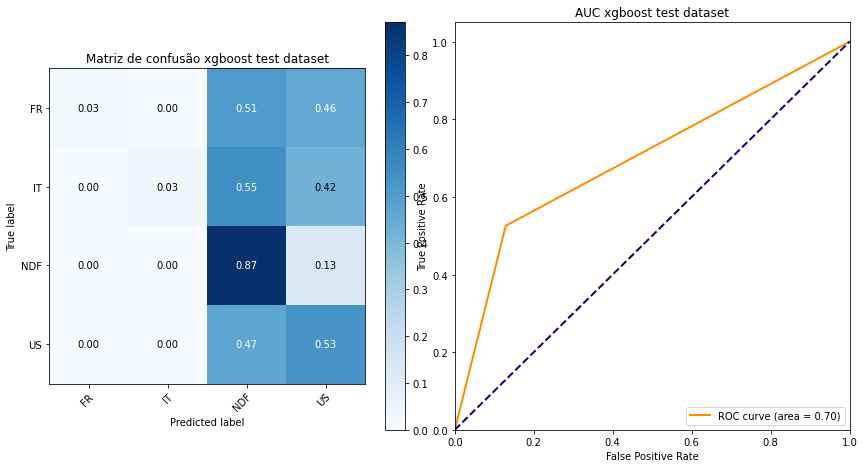

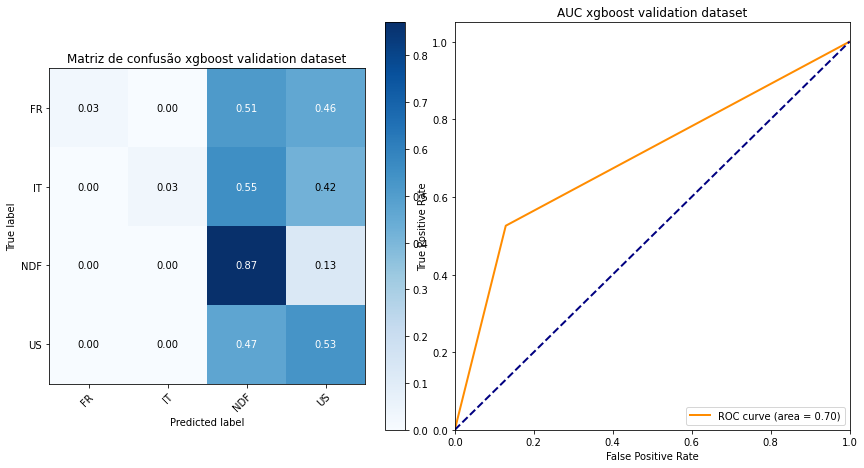

In [12]:
test_pred_proba = xgbc.predict_proba(test_X)
test_pred = xgbc.predict(test_X)

val_pred_proba = xgbc.predict_proba(val_X)
val_pred = xgbc.predict(val_X)

test_logloss = log_loss(test_y, test_pred_proba)
val_logloss = log_loss(val_y, val_pred_proba)
test_auc = plot_charts(test_y, test_pred, 'xgboost test dataset')
val_auc = plot_charts(test_y, test_pred, 'xgboost validation dataset', idx=2)

print(f'LOG LOSS - TEST: {test_logloss}')
print(f'LOG LOSS - VALIDATION: {val_logloss}')
print(f'AUC - TEST: {test_auc}')
print(f'AUC - VALIDATION: {val_auc}')

save_results('xgboost')

In [13]:
clf = DecisionTreeClassifier(random_state=SEED, max_depth=TREE_MAX_DEPTH)
clf.fit(train_X, train_y)

DecisionTreeClassifier(max_depth=6, random_state=2021)

LOG LOSS - TEST: 0.7099997054223935
LOG LOSS - VALIDATION: 0.721054556962506
AUC - TEST: 0.6702767297014274
AUC - VALIDATION: 0.6702767297014274


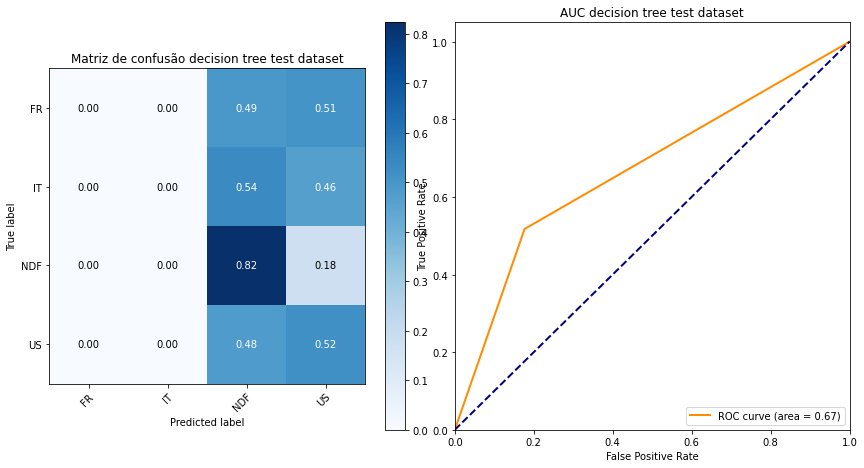

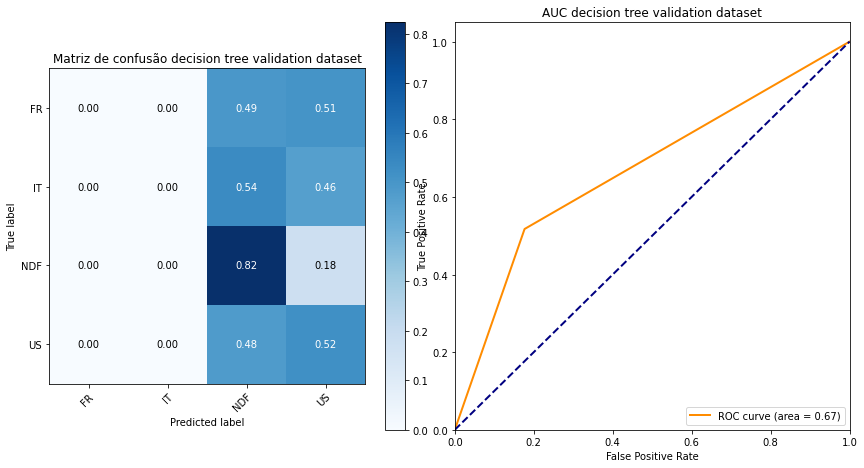

In [14]:
test_pred_proba = clf.predict_proba(test_X)
test_pred = clf.predict(test_X)

val_pred_proba = clf.predict_proba(val_X)
val_pred = clf.predict(val_X)

test_logloss = log_loss(test_y, test_pred_proba)
val_logloss = log_loss(val_y, val_pred_proba)
test_auc = plot_charts(test_y, test_pred, 'decision tree test dataset')
val_auc = plot_charts(test_y, test_pred, 'decision tree validation dataset', idx=2)

print(f'LOG LOSS - TEST: {test_logloss}')
print(f'LOG LOSS - VALIDATION: {val_logloss}')
print(f'AUC - TEST: {test_auc}')
print(f'AUC - VALIDATION: {val_auc}')

save_results('decision tree')

In [15]:
results = pd.read_csv(RESULTS_PATH)
results

,clf,test_logloss,val_logloss,test_auc,val_auc,downsample,n_per_class,smote,weighted_train
0,xgboost,0.635304,0.706703,0.698305,0.698305,False,10000,False,False
1,decision tree,0.710000,0.721055,0.670277,0.670277,False,10000,False,False
2,xgboost,1.025355,1.079894,0.717582,0.717582,False,10000,False,True
3,decision tree,0.710000,0.721055,0.670277,0.670277,False,10000,False,True
4,xgboost,0.965557,1.030763,0.709887,0.709887,True,20000,False,True
5,decision tree,0.790623,0.823179,0.685000,0.685000,True,20000,False,True
6,xgboost,0.696913,1.090284,0.693414,0.693414,False,20000,True,False
7,decision tree,0.902343,0.905252,0.670360,0.670360,False,20000,True,False
8,xgboost,1.058919,0.865919,0.676766,0.676766,True,20000,True,False
9,decision tree,0.938159,0.940523,0.677600,0.677600,True,20000,True,False


In [18]:
joblib.dump(xgbc, MODEL_PATH)

['outputs/model.sav']